In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, roc_auc_score
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import mean_absolute_error


In [2]:
iris = load_iris()
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [4]:
X = iris.data[:, 2:] 
target_names = iris.target_names
feature_names = iris.feature_names[2:]

y = iris.target

## Задача1

Task

criterion: “gini”, “entropy”. default=”gini”

Задание: постройте и визуализируйте структуру решающего дерева

для критерия разбиения “entropy"

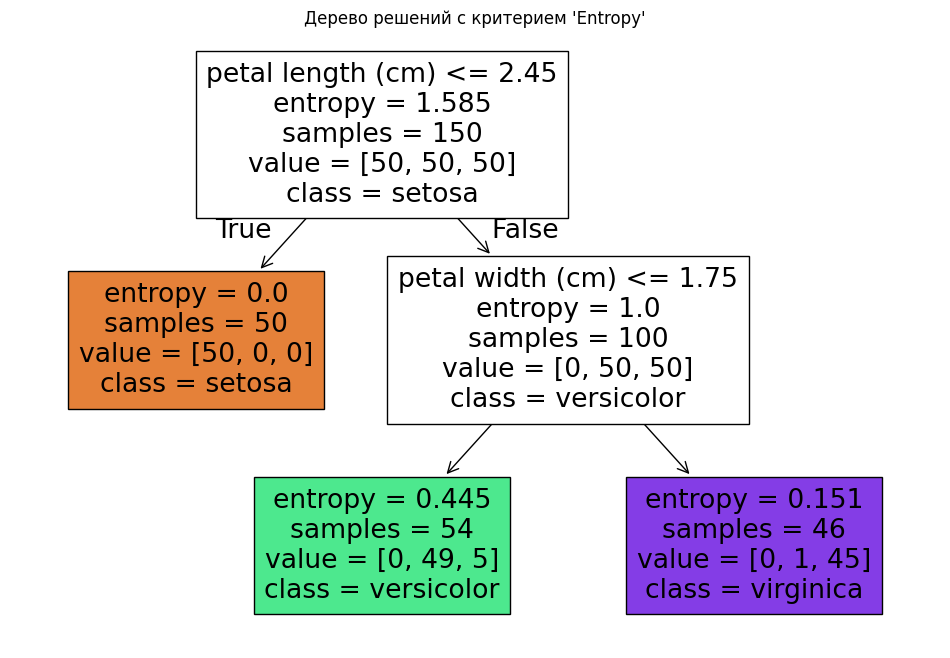

In [5]:
# Создаем классификатор дерева решений с использованием критерия "энтропия"
entropy_tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)
entropy_tree_clf.fit(X, y)

plt.figure(figsize=(12, 8))
tree.plot_tree(
    entropy_tree_clf,
    feature_names=iris.feature_names[2:], 
    class_names=iris.target_names, 
    filled=True
)
plt.title("Дерево решений с критерием 'Entropy'")
plt.show()


## 1.6 Прикладная задача: предсказание времени задержки

In [6]:
train = pd.read_csv('train_features.csv').fillna(0)
y = pd.read_csv('train_target.csv', index_col='id')

In [7]:
train.drop('Year', axis=1, inplace=True)
types = train.dtypes
real_cols = list(types[types != 'object'].index.values)

In [8]:
x_train, x_val, y_train, y_val = train_test_split(train, y, train_size=0.8, test_size=0.2, random_state=42)

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
dt = DecisionTreeRegressor()
dt.fit(x_train[real_cols], y_train)

DecisionTreeRegressor()

In [10]:
mse_train = []
mse_val = []
train_errors = []
val_errors = []

# Итерация по различным глубинам дерева
for depth in range(20):
    model = DecisionTreeRegressor(max_depth=depth * 5 + 1, min_samples_leaf=1000)
    model.fit(x_train[real_cols], y_train)
    
    # Расчёт ошибок на обучающей и валидационной выборках
    train_errors.append(mean_absolute_error(y_train, model.predict(x_train[real_cols])))
    val_errors.append(mean_absolute_error(y_val, model.predict(x_val[real_cols])))


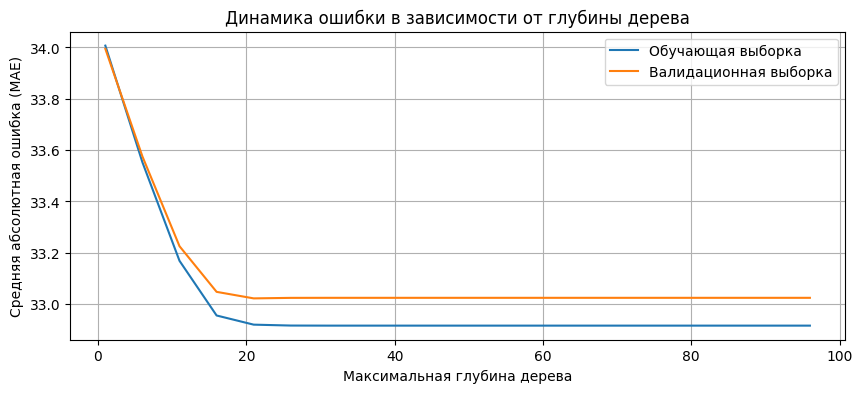

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(
    [depth * 5 + 1 for depth in range(20)], train_errors, label='Обучающая выборка'
)
plt.plot(
    [depth * 5 + 1 for depth in range(20)], val_errors, label='Валидационная выборка'
)
plt.title('Динамика ошибки в зависимости от глубины дерева')
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Средняя абсолютная ошибка (MAE)')
plt.legend()
plt.grid(True)
plt.show()

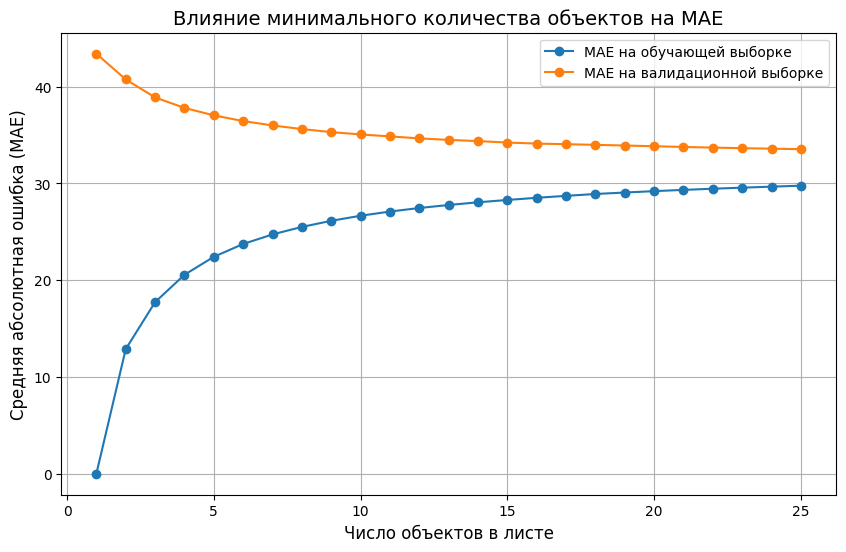

In [12]:
# серия моделей без регуляризации по количеству объектов в листе
train_mae = []
val_mae = []

leaf_counts = range(1, 26)

for leaf_count in leaf_counts:
    model = DecisionTreeRegressor(min_samples_leaf=leaf_count, random_state=42)
    model.fit(x_train[real_cols], y_train)
    
    train_mae.append(mean_absolute_error(y_train, model.predict(x_train[real_cols])))
    val_mae.append(mean_absolute_error(y_val, model.predict(x_val[real_cols])))

plt.figure(figsize=(10, 6))
plt.plot(leaf_counts, train_mae, label='MAE на обучающей выборке', marker='o')
plt.plot(leaf_counts, val_mae, label='MAE на валидационной выборке', marker='o')
plt.xlabel('Число объектов в листе', fontsize=12)
plt.ylabel('Средняя абсолютная ошибка (MAE)', fontsize=12)
plt.title('Влияние минимального количества объектов на MAE', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# модель с минимальным количеством объектов в листе равным 25
final_model = DecisionTreeRegressor(min_samples_leaf=25, random_state=42)
final_model.fit(x_train[real_cols], y_train)

train_error = mean_absolute_error(y_train, final_model.predict(x_train[real_cols]))
val_error = mean_absolute_error(y_val, final_model.predict(x_val[real_cols]))

print(f"MAE на обучающей выборке: {train_error}")
print(f"MAE на валидационной выборке: {val_error}")


MAE на обучающей выборке: 29.76461419851874
MAE на валидационной выборке: 33.53678625535291


## Ансамбли

In [19]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
bag_of_trees = BaggingRegressor(final_model, n_estimators=5, random_state=42)
bag_of_trees.fit(x_train[real_cols], y_train)
bag_mse_val = mean_absolute_error(bag_of_trees.predict(x_val[real_cols]), y_val)
bag_mse_train = mean_absolute_error(bag_of_trees.predict(x_train[real_cols]), y_train)

c:\Users\nosko\OneDrive\Рабочий стол\cse2\venv\Lib\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


## Задача: выбрать оптимальное количество регрессоров, оптимальные параметры для Bagging Regressor
## Выбрать оптимальные параметры для каждого дерева.

In [22]:
from sklearn.model_selection import GridSearchCV

y_train_flat = y_train.values.ravel()

x_train = x_train.apply(pd.to_numeric, errors='coerce')
y_train_flat = pd.to_numeric(y_train_flat, errors='coerce')

param_grid = {
    'n_estimators': [2, 4, 6, 8],
    'max_samples': [0.4, 0.7, 1.0],
    'max_features': [0.4, 0.7, 1.0]
}

bagging_regressor = BaggingRegressor(estimator=final_model, random_state=42, n_jobs=-1)

grid_search = GridSearchCV(bagging_regressor, param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_search.fit(x_train, y_train_flat)

print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'Лучший MAE: {-grid_search.best_score_}')

Лучшие параметры: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 8}
Лучший MAE: 32.418156623906874


In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [4, 6, 8, 10],
    'max_depth': [None, 4, 6, 8],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


rf_regressor = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search_rf = GridSearchCV(rf_regressor, param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(x_train[real_cols], y_train)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


c:\Users\nosko\OneDrive\Рабочий стол\cse2\venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
432 fits failed out of a total of 1296.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
174 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\nosko\OneDrive\Рабочий стол\cse2\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\nosko\OneDrive\Рабочий стол\cse2\venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\nosko\OneDrive\Рабочий стол\cse2\venv\Lib\site-packages\sklearn\base.py", line 666, in _validate_pa

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 4, 6, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [4, 6, 8, 10]},
             scoring='neg_mean_absolute_error', verbose=2)

In [28]:
print(f'Лучшие параметры: {grid_search_rf.best_params_}')
print(f'Лучший MAE: {-grid_search_rf.best_score_}')

Лучшие параметры: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10}
Лучший MAE: 32.88089185980917


## 2. Boosting

In [29]:
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import numpy as np
import pandas as pd
import pickle
from nltk.corpus import stopwords
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nosko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Задача. Варьируя параметры ансамбля в подходам блэндинг и стэкинг, обучить оптимальный классификатор.
## Визуализировать графики зависимости предсказания от параметров модели.

In [30]:
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

dataset = load_dataset('json', data_files={'train': 'train.jsonl', 'test': 'validation.jsonl'})

vectorizer = CountVectorizer(
    max_features=500, 
    min_df=4, 
    max_df=0.7, 
    stop_words=stopwords.words('english')
)

X_train_vec = vectorizer.fit_transform(dataset['train']['text'])

vocabulary = vectorizer.get_feature_names_out()

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)

X_test_vec = vectorizer.transform(dataset['test']['text'])
X_test_tfidf = tfidf_transformer.transform(X_test_vec)

X_train = X_train_tfidf.toarray()
X_test = X_test_tfidf.toarray()

y_train = dataset['train']['label']
y_test = dataset['test']['label']

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.33, random_state=42
)


Обучение модели AdaBoost...


c:\Users\nosko\OneDrive\Рабочий стол\cse2\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Точность AdaBoost: 0.47
Обучение модели Gradient Boosting...
Точность Gradient Boosting: 0.65
Обучение модели Random Forest...
Точность Random Forest: 0.66
Обучение модели стэкинга...


c:\Users\nosko\OneDrive\Рабочий стол\cse2\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nosko\OneDrive\Рабочий стол\cse2\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nosko\OneDrive\Рабочий стол\cse2\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\nosko\OneDrive\Рабочий стол\cse2\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Точность модели стэкинга: 0.66


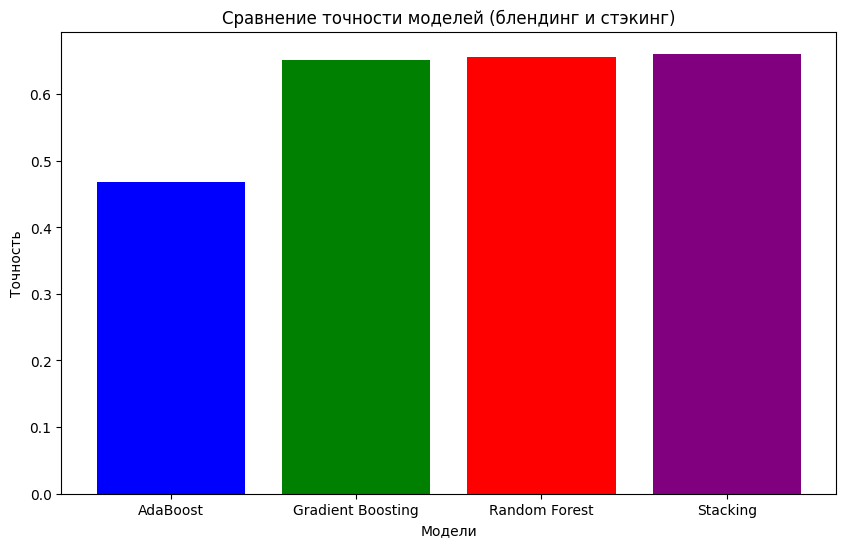

In [31]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Определение моделей для блендинга и стэкинга
base_classifiers = [
    ("AdaBoost", AdaBoostClassifier(n_estimators=50, random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42))
]

# Стэкинг классификаторов
stacking_classifier = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=LogisticRegression(random_state=42)
)

# Словарь для хранения точности моделей
model_performance = {}

# Обучение и оценка базовых моделей
for name, classifier in base_classifiers:
    print(f"Обучение модели {name}...")
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_performance[name] = accuracy
    print(f"Точность {name}: {accuracy:.2f}")

# Обучение и оценка модели стэкинга
print("Обучение модели стэкинга...")
stacking_classifier.fit(X_train, y_train)
stacking_preds = stacking_classifier.predict(X_test)
stacking_accuracy = accuracy_score(y_test, stacking_preds)
model_performance["Stacking"] = stacking_accuracy
print(f"Точность модели стэкинга: {stacking_accuracy:.2f}")

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.bar(model_performance.keys(), model_performance.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Модели')
plt.ylabel('Точность')
plt.title('Сравнение точности моделей (блендинг и стэкинг)')
plt.show()
